In [1]:
import io, requests
import http.client, urllib.request, urllib.parse, urllib.error, base64, json
from pprint import pprint
from PIL import Image, ImageDraw

from matplotlib.pyplot import imshow
%matplotlib inline


subscription_key = 'f7b8dca3c389408e8383636d13960a8d'
uri_base = 'https://westeurope.api.cognitive.microsoft.com/vision/v1.0'
headers = {
    # Request headers.
    'Content-Type': 'application/json',
    'Ocp-Apim-Subscription-Key': subscription_key,
}

params = urllib.parse.urlencode({
    # Request parameters. The language setting "unk" means automatically detect the language.
    'language': 'unk',
    'detectOrientation ': 'true',
})

In [19]:
images = [
    {
        'img_url': "https://www.mad.tf.fau.de/files/2017/07/coffee_touchscreen_test_50.jpg",
        'grid': (4,3)
    },
    {
        'img_url': "https://www.mad.tf.fau.de/files/2017/07/coffee_2.jpg",
        'grid': (4,2)
    },
    {
        'img_url': "https://www.mad.tf.fau.de/files/2017/07/settings_touchscreen.jpg",
        'grid': (2,2)
    },
    {
        'img_url': "https://www.mad.tf.fau.de/files/2017/07/img_test_1.png",
        'grid': (4,2)
    },
    {
        'img_url': "https://www.mad.tf.fau.de/files/2017/07/img_test_2.png",
        'grid': (3,2)
    },
    {
        'img_url': "https://www.mad.tf.fau.de/files/2017/07/computer_touchscreen.png",
        'grid': (3,6)
    },
    {
        'img_url': "https://www.mad.tf.fau.de/files/2017/07/apple_touchscreen.jpg",
        'grid': (3,2)
    }
]

image = images[1]

# The URL of a JPEG image containing text.
body = "{'url':\"%s\"}" % image['img_url']

fd = urllib.request.urlopen(image['img_url'])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)

#bb_size = (280, 220)
#bb_size = (450, 450)
grid = image['grid']
offset = (50, 20)
scale = 0.8
bb_size = ((scale * im.width) / grid[0] - offset[0], (scale * im.height) / grid[1] - offset[1])
#print(bb_size)

#im

[{'coords': [32.599999999999966, 528, 526.4000000000001, -52.0],
  'text': ' Latte'},
 {'coords': [47.599999999999966, 1344, 541.4000000000001, 764.0],
  'text': ' Water'},
 {'coords': [814.5999999999999, 528, 1308.4, -52.0], 'text': ' Mocha'},
 {'coords': [834.0999999999999, 1350, 1327.9, 770.0], 'text': ' Milk'},
 {'coords': [1498.1, 527, 1991.9, -53.0], 'text': ' Chocolate'},
 {'coords': [1497.6, 1349, 1991.4, 769.0], 'text': ' Sugar'},
 {'coords': [2207.6, 527, 2701.4, -53.0], 'text': ' Chocomilk'},
 {'coords': [2206.1, 1354, 2699.9, 774.0], 'text': ' Start'}]


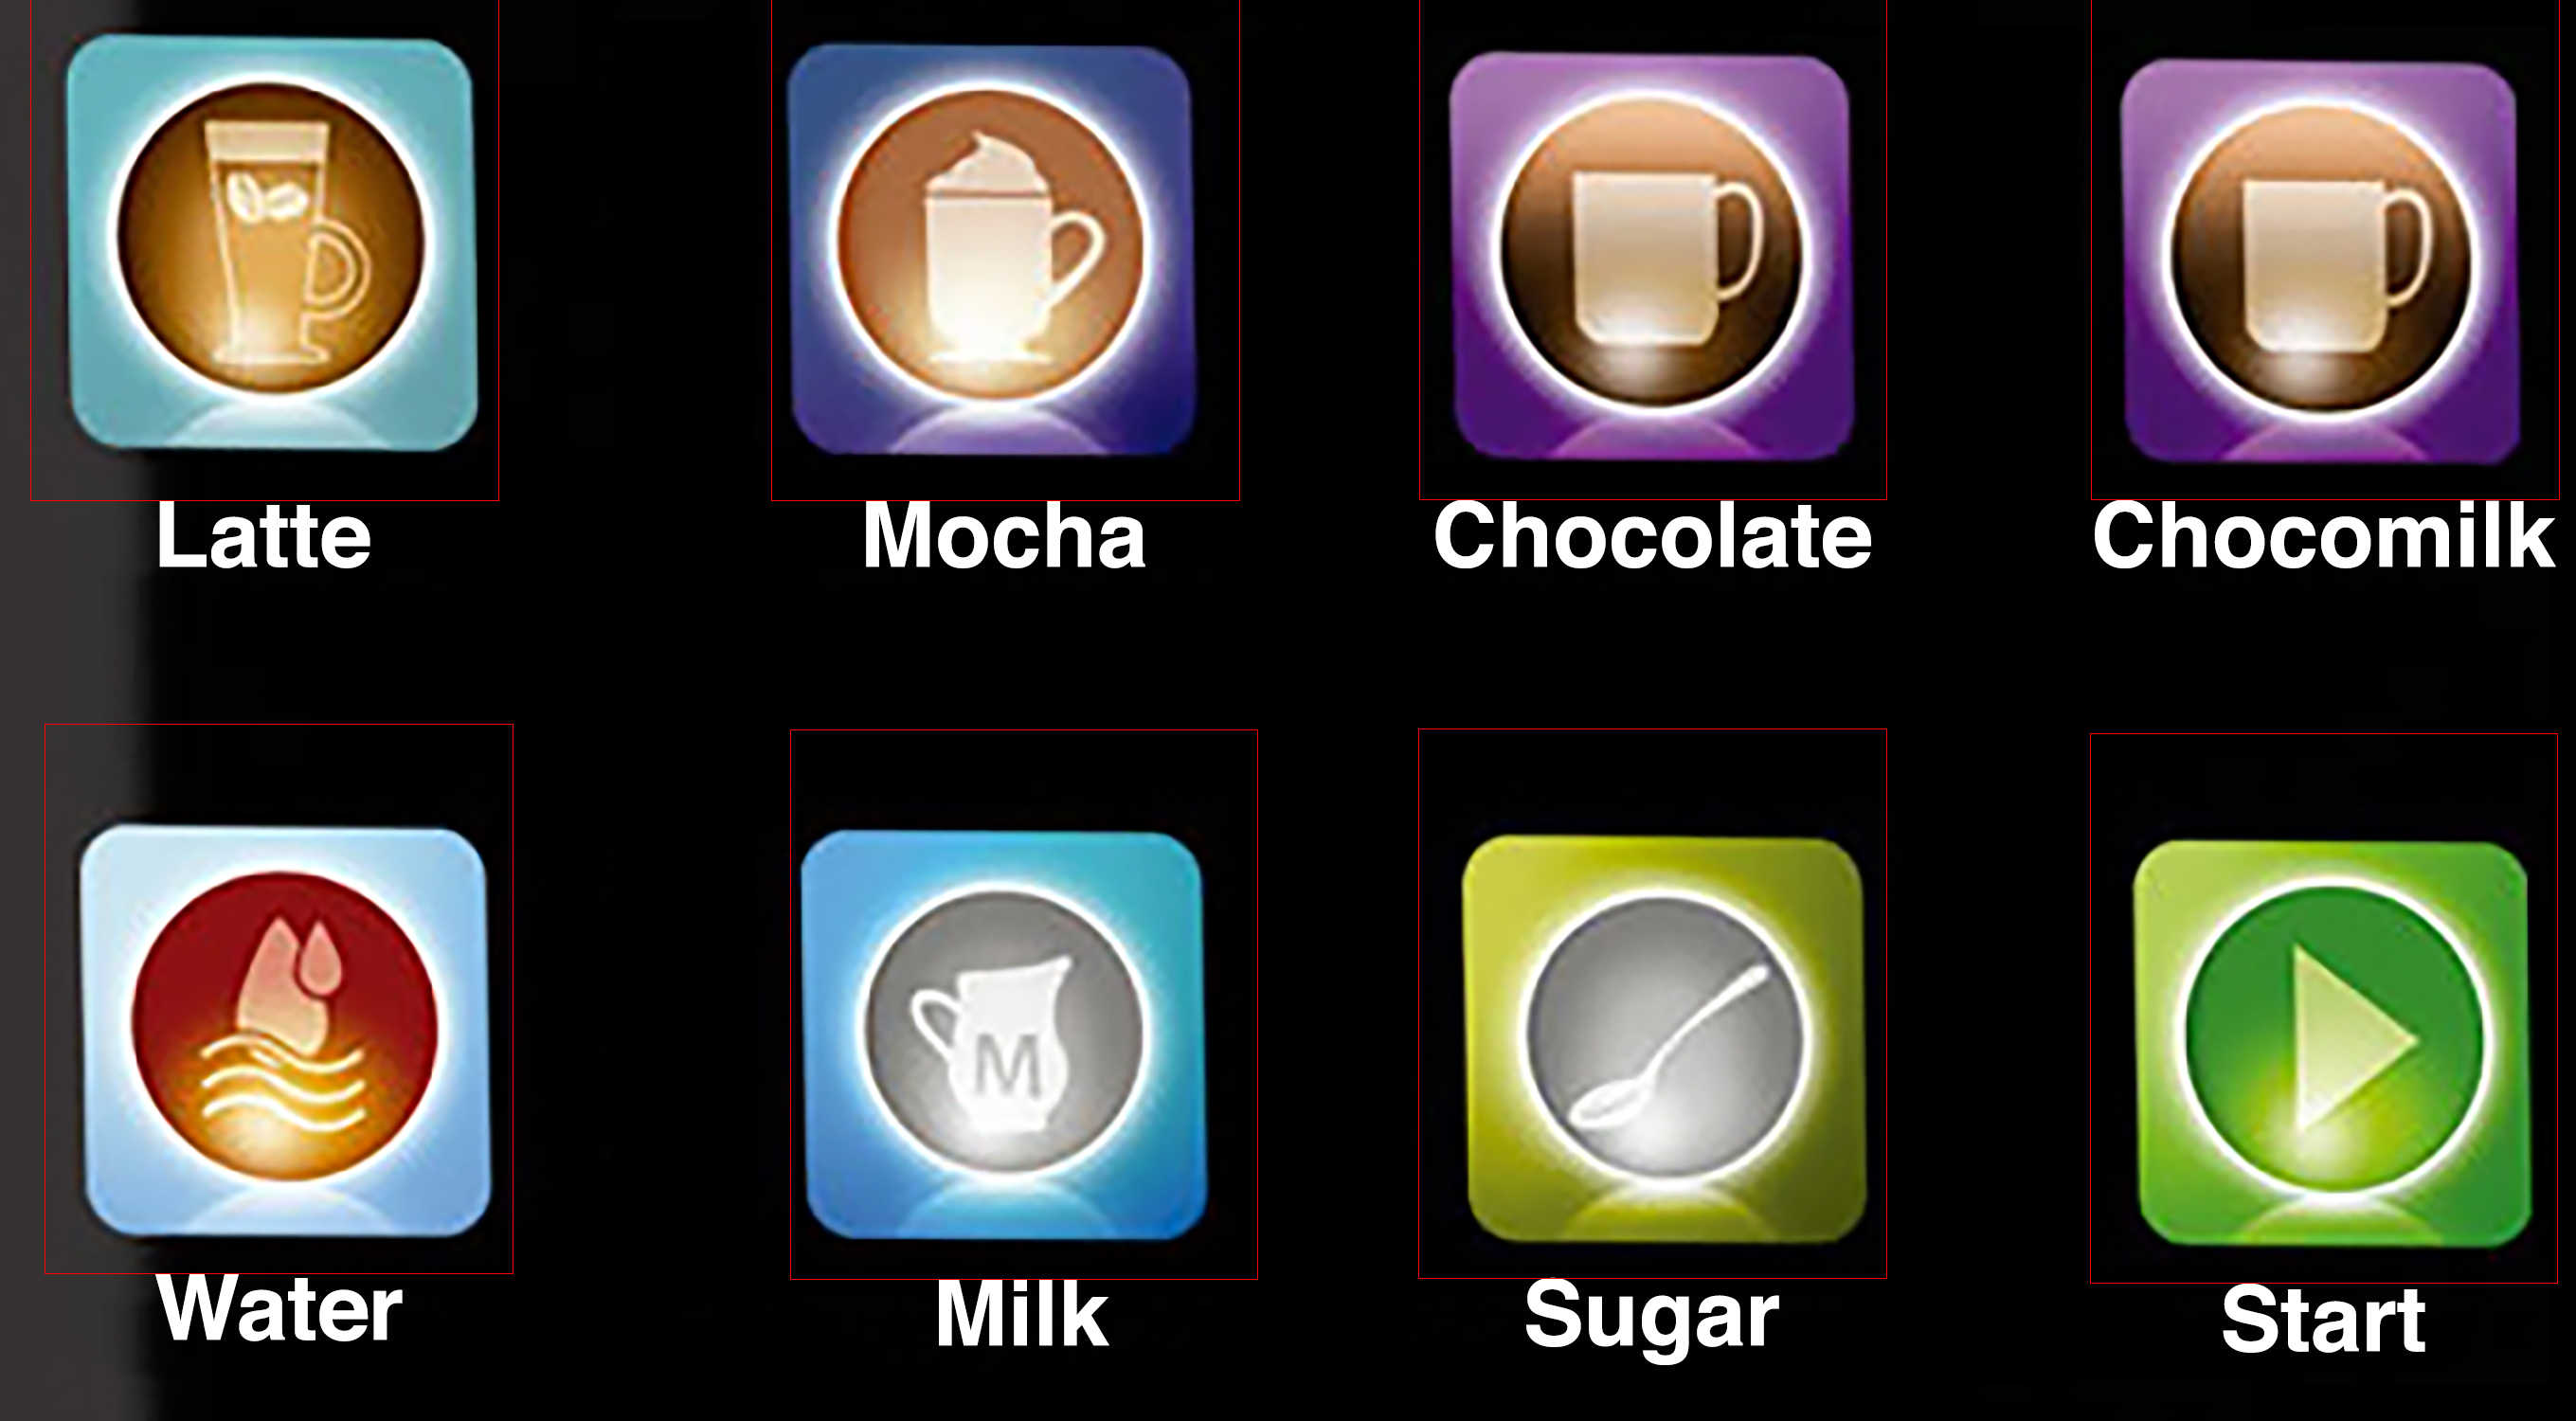

In [20]:
# Execute the REST API call and get the response.
conn = http.client.HTTPSConnection('westeurope.api.cognitive.microsoft.com')
conn.request("POST", "/vision/v1.0/ocr?%s" % params, body, headers)
response = conn.getresponse()
data = response.read().decode()
conn.close()

# 'data' contains the JSON data. The following formats the JSON data for display.
parsed_raw = json.loads(data)
parsed_words = parsed_raw["regions"]
parsed_str = json.dumps(parsed_words, sort_keys=True, indent=2)
#print(len(parsed_words))

im = Image.open(image_file)
draw = ImageDraw.Draw(im)
list_boxes = list()
list_bbs = list()

#pprint(parsed_words)

for r in range(len(parsed_words)):
    #print("\n----- Region %i -----" % r)
    if r >= len(parsed_words):
        break
    region = parsed_words[r]
    bb_region = [int(x) for x in region["boundingBox"].split(",",4)]
    #pprint(region)
    if (r > 0) and (abs(bb_region[0] - list_bbs[r-1][0]) > 20) and (abs(bb_region[0] - list_bbs[r-1][0]) < bb_size[0]):
        print("merge %i and %i!" % (r-1, r))
        curr_bb = [list_bbs[r-1][0], list_bbs[r-1][1], list_bbs[r-1][2] + bb_region[2], list_bbs[r-1][3]]
        list_bbs.append(curr_bb)
        parsed_words[r]["boundingBox"] = curr_bb
        parsed_words[r]["lines"][0]["words"] = parsed_words[r-1]["lines"][0]["words"] + region["lines"][0]["words"]
        parsed_words[r]["lines"][0]["boundingBox"] = curr_bb
        #bb_old = parsed_words[r-1]["lines"][0]["boundingBox"]
        #bb_current = region["lines"][0]["boundingBox"]
        #parsed_words[r]["lines"][0]["boundingBox"] = [bb_old[0], ]
        popped = parsed_words.pop(r-1)
        region = parsed_words[r]
        r = r - 1

    list_bbs.append(bb_region)

#pprint(parsed_words)

for region in parsed_words:
    for l, line in enumerate(region["lines"]):
        dict_box = dict()
        #print(l)
        #print(line["words"])
        dict_box["text"] = ""
        if (type(line["boundingBox"]) is type("str")):
            coords_text = [int(x) for x in line["boundingBox"].split(",", 4)]
        else:
            coords_text = line["boundingBox"]
        x_center = coords_text[0] + 0.5 * coords_text[2]
        #dict_box["coords"][2] = dict_box["coords"][0] + bb_size[1]
        #dict_box["coords"][3] = dict_box["coords"][1] - bb_size[0]

        dict_box["coords"] = [x_center - 0.5 * bb_size[0], 
                              coords_text[1], 
                              x_center + 0.5 * bb_size[0],
                              coords_text[1] - bb_size[1]]
        #print(dict_box["coords"])
        draw.rectangle(dict_box["coords"], outline=(255,0,0,255))
        for w, word in enumerate(line["words"]):
            dict_box["text"] = dict_box["text"] + " " + word["text"]
            #print("\n [%i, %i, %i] ---  %s" % (r, l, w, word["text"]))

        list_boxes.append(dict_box)

pprint(list_boxes)

file = open("touchscreen_tiles.json", 'w')
file.write(json.dumps(list_boxes, indent=4))
file.close()

im